# RAG Pipeline for Smart Contract Generation

This notebook demonstrates the complete workflow of converting legal documents into smart contracts using RAG (Retrieval Augmented Generation) and LLM.

In [1]:
from ctransformers import AutoModelForCausalLM

import torch

print(torch.cuda.is_available())

# Initialize LLM
llm = AutoModelForCausalLM.from_pretrained(
    '../models/codellama-7b-instruct.Q5_K_M.gguf',
    model_type='llama',
    gpu_layers=100,
    context_length=8192,
)

/home/danila/master_thesis/llm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
with open('../docs/contract_prompt.txt', 'r') as file:
    contract_prompt = file.read()

In [3]:
with open('../docs/short-term-vacation-lease-agreements/agreement_1.txt', 'r') as file:
    rental_agreement = file.read()

In [4]:
# Prepare the combined prompt
prompt = f"""
{contract_prompt}

Here is a sample rental agreement for reference:
{rental_agreement}

Solidity contract:
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

// Begin implementation below:
"""

# Configure generation parameters
generation_config = {
    'temperature': 0.2,
    'top_p': 0.95,
    'max_new_tokens': 2500,
    'stop': ['// End of contract', '```', '// End implementation'],
    'repetition_penalty': 1.1
}

In [5]:
# Generate initial contract from LLM
# initial_contract = llm(prompt, **generation_config)
# print('Generated initial contract:')
# print(initial_contract)

In [10]:
from langchain_community.llms import CTransformers
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

import rag


model = CTransformers(model='../models/codellama-7b-instruct.Q5_K_M.gguf',
                      model_type='llama', context_length=8192, gpu_layers=100)
templates = rag.load_templates("../templates/")
embeddings = SentenceTransformerEmbeddings(
    model_name="all-MiniLM-L6-v2", model_kwargs={'device': 'cuda'})
vector_store = rag.create_vector_store(embeddings, templates, )
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200)
rag_chain = rag.create_chain(vector_store, model, text_splitter)

Loading templates from: ../templates/


100%|██████████| 15/15 [00:00<00:00, 19448.09it/s]

Loaded 15 template documents.


Creating vector store...
Vector store created successfully.
Setting up RAG chain...
RAG chain setup complete.


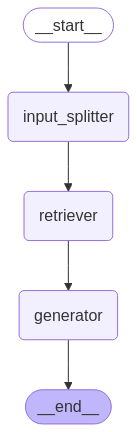

In [11]:
from IPython.display import Image, display

display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [12]:
agreement_part = """
  4.  SECURITY DEPOSIT. The Tenant shall be obligated to pay the following amounts upon the execution of this Agreement: (check one)

  ☑ - Security Deposit: $3000 (“Security Deposit”). The Security Deposit is for the faithful performance of the Tenant under the terms and conditions of this Agreement. The Tenant must pay the Security Deposit at the execution of this Agreement. The Security Deposit shall be returned to the Tenant within the State's requirements after the end of the Lease Term less any itemized deductions. This Security Deposit shall not be credited towards any Rent unless the Landlord gives their written consent.
"""

print(vector_store.similarity_search(agreement_part)[0].page_content)

4. SECURITY DEPOSIT. The Tenant shall be obligated to pay the following
amounts upon the execution of this Agreement: (check one)

☐ - No Security Deposit: There is no deposit required for the security
of this Agreement (“Security Deposit”).

☐ - Security Deposit: $[SECURITY DEPOSIT AMOUNT] (“Security Deposit”).
The Security Deposit is for the faithful performance of the Tenant
under the terms and conditions of this Agreement. The Tenant must pay
the Security Deposit at the execution of this Agreement. The Security
Deposit shall be returned to the Tenant within the State's
requirements after the end of the Lease Term less any itemized
deductions. This Security Deposit shall not be credited towards any
Rent unless the Landlord gives their written consent.


In [13]:
print("Invoking RAG chain...")
generated_contract = rag_chain.invoke({"question": rental_agreement})

print("\n--- Generated Solidity Contract ---")
print(generated_contract)
print("---------------------------------------------")

Invoking RAG chain...


InvalidUpdateError: Expected dict, got SHORT-TERM RENTAL AGREEMENT

1.  THE PARTIES. This Short-Term Rental Agreement (“Agreement”) made on January 15, 2024, between the following:

  Landlord: Alice Wonderland, with a mailing address of 123 Main St, Anytown, USA 12345 (“Landlord”), and

  Tenant: Bob The Builder, with a mailing address of 456 Oak Ave, Sometown, USA 67890 (“Tenant”).

  Occupant(s): Carol The Carpenter.

2.  THE PREMISES. The Landlord agrees to lease the described property below to the Tenant, and the Tenant agrees to rent from the Landlord:

a.  Mailing Address: 789 Pine Ln, Vacationville, USA 11223

b.  Residence Type: ☑ House ☐ Apartment ☐ Condo ☐ Other: 

c.  Bedroom(s): 3

d.  Bathroom(s): 2

e.  Other: Lake view

  Hereinafter known as the “Premises.”

3.  LEASE TERM. The Tenant shall have access to the Premises under the terms of this Agreement for the following time period: (check one)

  ☑ - Fixed Term. The Tenant shall occupy the Premises starting February 1, 2024, at 3:00 PM and ending February 8, 2024, at 11:00 AM (“Lease Term”).

4.  SECURITY DEPOSIT. The Tenant shall be obligated to pay the following amounts upon the execution of this Agreement: (check one)

  ☑ - Security Deposit: $500 (“Security Deposit”). The Security Deposit is for the faithful performance of the Tenant under the terms and conditions of this Agreement. The Tenant must pay the Security Deposit at the execution of this Agreement. The Security Deposit shall be returned to the Tenant within the State's requirements after the end of the Lease Term less any itemized deductions. This Security Deposit shall not be credited towards any Rent unless the Landlord gives their written consent.

5.  RENT. The Tenant shall pay the Landlord:

  ☑ - Fixed Amount. The Tenant shall be required to pay the Landlord $1200 for the Lease Term (“Rent”). The full amount of the Rent is due at the execution of this Agreement.

6.  UTILITIES. The Landlord shall be responsible for all utilities and services to the Premises EXCEPT for the following: Electricity, Internet

7.  PETS. The Landlord: (check one)

  ☑ - Allows Pets. The Tenant shall have the right to have 1 pet(s) on the Premises with a maximum limit of 20 pounds per pet. For the right to have pet(s) on the Premises, the Landlord shall charge a deposit of $100 that is ☑ refundable unless there are damages related to the pet. The Tenant is responsible for all damage that any pet causes, regardless of the ownership of said pet, and agrees to restore the Premises to its original condition at their expense.

8.  PARKING. The Landlord: (check one)

  ☑ - Shall Provide Parking. 1 parking space(s) to the Tenant for a fee of $50 to be paid ☑ at the execution of this Agreement ☐ on a monthly basis in addition to the rent. The parking space(s) are described as: Space #A

9.  FEES. The Landlord requires the Tenant pays the following fees at the execution of this Agreement: (check all that apply)

  ☑ - Cleaning Fee: $150

  ☑ - Taxes: $80

  ☐ - Other: 

10. SMOKING POLICY. (check one)

  ☑ - Smoking is Not Allowed.

11. PROPERTY MANAGER. The Landlord: (check one)

  ☑ - Does Not Have a Property Manager.

  Landlord’s Telephone: 555-1234

  Landlord’s E-Mail: alice.wonderland@email.com

12. SUBLETTING. The Tenant: (check one)

  ☑ - Cannot Sublet the Premises.

13. GUESTS. During the Lease Term, the Tenant is: (check one)

  ☑ - Allowed to Have Guests. Rules regarding guests are as follows:

a.  Maximum Number of Guests: 4

b.  Maximum Stay: 72 Hours

c.  Other Rules: 

14. QUIET HOURS. The Landlord requires: (check one)

  ☑ - Quiet Hours. Quiet hours begin at 10:00 PM each night and continue until sunrise. Quiet hours consist of no music and keeping all audio at a minimum level out of respect for the surrounding residents.

15. MOVE-IN INSPECTION. Before, at the time of the Tenant accepting possession, or shortly thereafter, the Landlord and Tenant shall: (check one)

  ☑ - Inspect the Premises. Both the Landlord and Tenant shall inspect the Premises and write any current damages and/or needed repairs on a move-in checklist.

16. INSPECTION. The Landlord has the right to inspect the Premises with prior notice as in accordance with State law. Should the Tenant violate any of the terms of this Agreement, the rental period shall be terminated immediately in accordance with State law. The Tenant waives all rights to process if they fail to vacate the premises upon termination of the rental period. The Tenant shall vacate the Premises at the expiration time and date of this agreement.

17. MAINTENANCE AND REPAIRS. The Tenant shall maintain the Premises in a good, clean, and ready-to-rent condition and use the Premises only in a careful and lawful manner. The Tenant shall leave the Premises in a ready to rent condition at the expiration of this Agreement, defined by the Landlord as being immediately habitable by the next tenant. The Tenant shall pay for maintenance and repairs should the Premises be left in a lesser condition. The Tenant agrees that the Landlord shall deduct costs of said services from any Security Deposit prior to a refund if Tenant causes damage to the Premises or its furnishings.

18. TRASH. The Tenants shall dispose of all waste material generated during the Lease Term under the strict instruction and direction of the Landlord.

19. QUIET ENJOYMENT. The Tenant, along with neighbors, shall enjoy each other’s company in a quiet and respectful manner to each other’s enjoyment. The Tenant is expected to behave in a civilized manner and shall be good neighbors with any residents of the immediate area. Creating a disturbance of the area by large gatherings or parties shall be grounds for immediate termination of this Agreement.

20. LANDLORD’S LIABILITY. The Tenant and any of their guests hereby indemnify and hold harmless the Landlord against any and all claims of personal injury or property damage or loss arising from the use of the Premises regardless of the nature of the accident, injury or loss. The Tenant expressly recognizes that any insurance for property damage or loss which the Landlord may maintain on the property does not cover the personal property of Tenant and that Tenant should purchase their own insurance for their guests if such coverage is desired.

21. ATTORNEY’S FEES. The Tenant agrees to pay all reasonable costs, attorney's fees, and expenses that shall be made or incurred by the Landlord enforcing this agreement.

22. USE OF PREMISES. The Tenant shall use the Premises for residential use only. The Tenant is not authorized to sell products or services on the Premises or conduct any commercial activity.

23. ILLEGAL ACTIVITY. The Tenant shall use the Premises for legal purposes only. Any other such use that includes but is not limited to illicit drug use, verbal or physical abuse of any person or illegal sexual behavior shall cause immediate termination of this Agreement with no refund of pre-paid Rent.

24. POSSESSIONS. Any personal items or possessions that are left on the Premises are not the responsibility of the Landlord. The Landlord shall make every reasonable effort to return the item to the Tenant. If claims are not made within the State’s required time period or two (2) weeks, whichever is greater, the Landlord shall be able to keep such items to sell or for personal use.

25. GOVERNING LAW. This Agreement shall be governed and subject to the laws located in the jurisdiction of Premise’s location.

26. ADDITIONAL TERMS & CONDITIONS. No loud parties after 10 PM.

IN WITNESS WHEREOF, the parties hereto have executed this Agreement as of the day and year first above written.

Landlord Signature: ____________________________ Date: __________________

Print Name: Alice Wonderland

Tenant Signature: ____________________________ Date: __________________

Print Name: Bob The Builder
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE